In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn

In [2]:
#Making the image size as a standard
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 15

In [7]:
#importing the csv file 
df_train = pd.read_csv('/Bangalore_1990_2022_BangaloreCity.csv')
df_train.head()

,time,tavg,tmin,tmax,prcp
0,01-01-1990,22.9,19.1,28.4,NaN
1,02-01-1990,21.7,NaN,26.5,0.0
2,03-01-1990,21.0,16.4,26.5,0.0
3,04-01-1990,20.8,NaN,27.4,0.0
4,05-01-1990,20.4,14.2,26.1,0.0


In [8]:
df_test = pd.read_csv('/Bangalore_1990_2022_BangaloreCity.csv')
df_test.head()

,time,tavg,tmin,tmax,prcp
0,01-01-1990,22.9,19.1,28.4,NaN
1,02-01-1990,21.7,NaN,26.5,0.0
2,03-01-1990,21.0,16.4,26.5,0.0
3,04-01-1990,20.8,NaN,27.4,0.0
4,05-01-1990,20.4,14.2,26.1,0.0


In [10]:
#Now by using concat function merging both as a single one
df = pd.concat((df_test, df_train), ignore_index=True)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by=['time'])

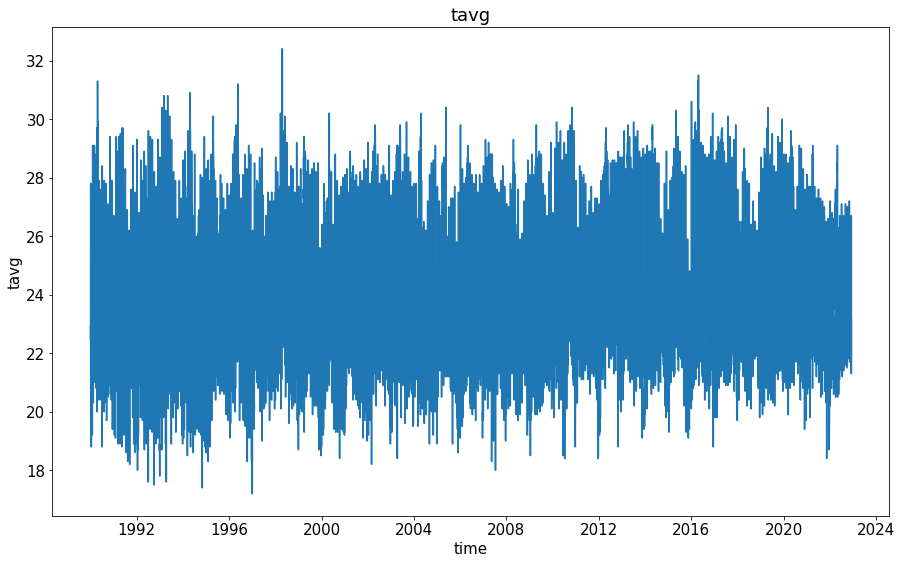

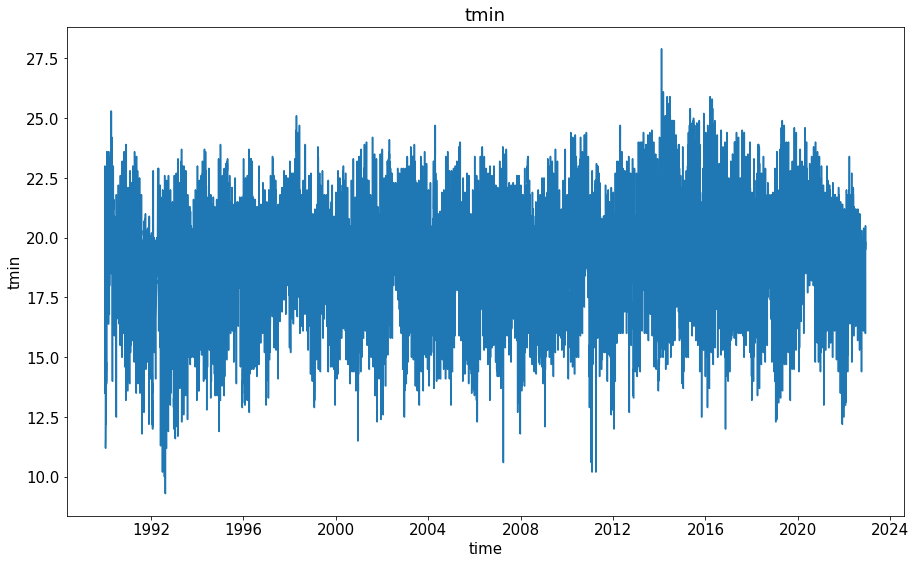

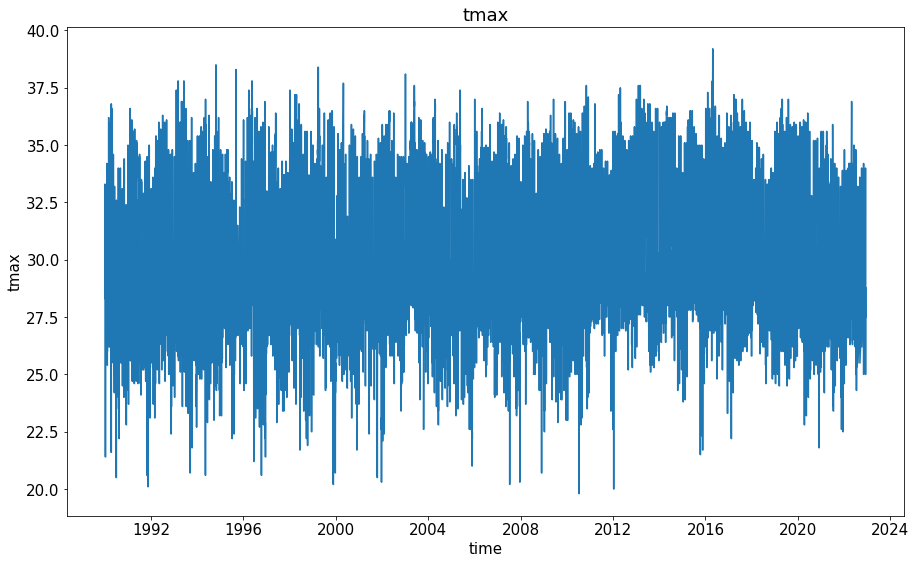

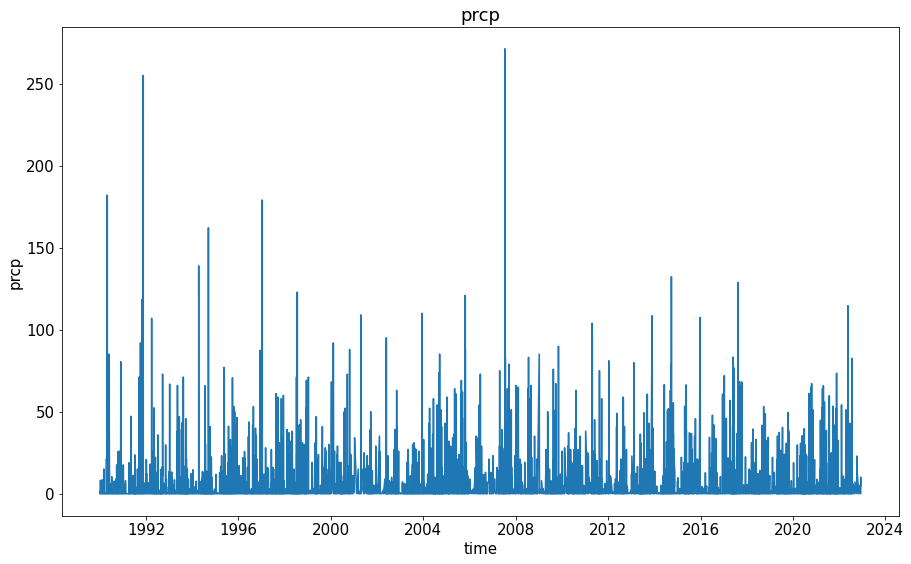

In [11]:
columns=df.drop(columns=['time']).columns
for column in columns:
  sns.lineplot(x=df['time'],y=df[column])
  plt.title(column)
  plt.show()

In [12]:
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

The function above is simple, but very usefull. With it we can create our time series, varying the size of the window, offset and the feature we want for our new dataset

In [13]:
# scale all the dataset (not including the time)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='time'))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns='time').columns)

# Set the window to 10
window = 10
feature_columns = ['tavg', 'tmin', 'tmax', 'prcp']

# Create a window with all the columns as features (excluding the time)
feature, target = create_window(df_scaled['prcp'],df_scaled[feature_columns], window=window)
print(feature[0])
print(target[0])
print(df_scaled.head(12))

[[-0.40714588 -0.12045444 -0.51824372         nan]
 [-0.40714588 -0.12045444 -0.51824372         nan]
 [-0.62361467 -2.486192    0.56366541 -0.33971062]
 [-0.62361467 -2.486192    0.56366541 -0.33971062]
 [ 0.93496066  0.85118777  0.52985575 -0.33971062]
 [ 0.93496066  0.85118777  0.52985575 -0.33971062]
 [ 1.71424832  1.52711279         nan -0.33971062]
 [ 1.71424832  1.52711279         nan -0.33971062]
 [ 1.23801697         nan  1.13842964 -0.2242706 ]
 [ 1.23801697         nan  1.13842964 -0.2242706 ]]
[-0.33971062]
        tavg      tmin      tmax      prcp
0  -0.407146 -0.120454 -0.518244       NaN
1  -0.407146 -0.120454 -0.518244       NaN
2  -0.623615 -2.486192  0.563665 -0.339711
3  -0.623615 -2.486192  0.563665 -0.339711
4   0.934961  0.851188  0.529856 -0.339711
5   0.934961  0.851188  0.529856 -0.339711
6   1.714248  1.527113       NaN -0.339711
7   1.714248  1.527113       NaN -0.339711
8   1.238017       NaN  1.138430 -0.224271
9   1.238017       NaN  1.138430 -0.224271
10

In [14]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.9):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

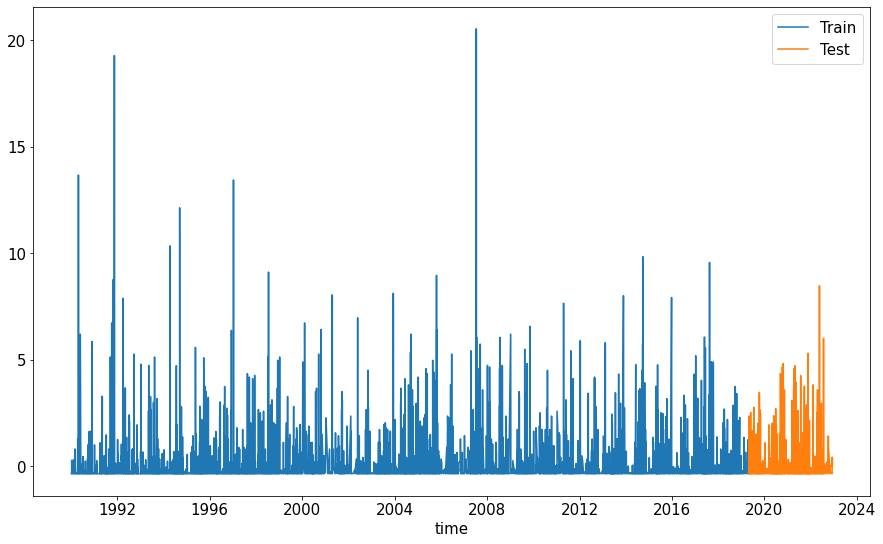

In [15]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
sns.lineplot(x=df['time'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['time'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

now moving to prediction

In [16]:
def model_lstm(x_shape):

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=(x_shape[1], x_shape[2])))
    model.add(keras.layers.Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model

In [17]:
model = model_lstm(x_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [32]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 2/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 3/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 4/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 5/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 6/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 7/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 8/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 9/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 10/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 11/50
669/669 [==============================] - 4s 6

In [36]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

# Function to print the y_predicted compared with the y_test
def print_test_x_prediction(y_test, y_predict, df_date, train_size, window=0):
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_test[:,0], label = 'Test')
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_predict[:,0], label = 'Predict')
    plt.show()

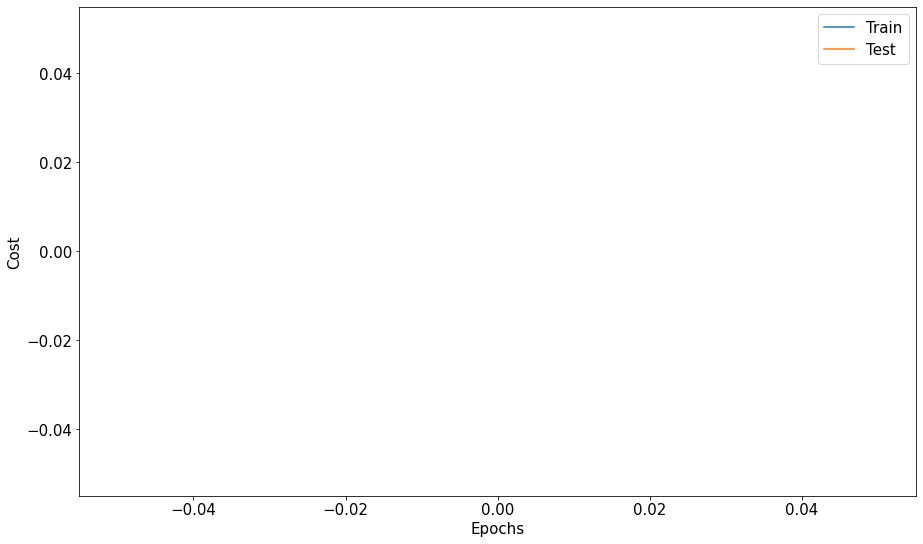

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


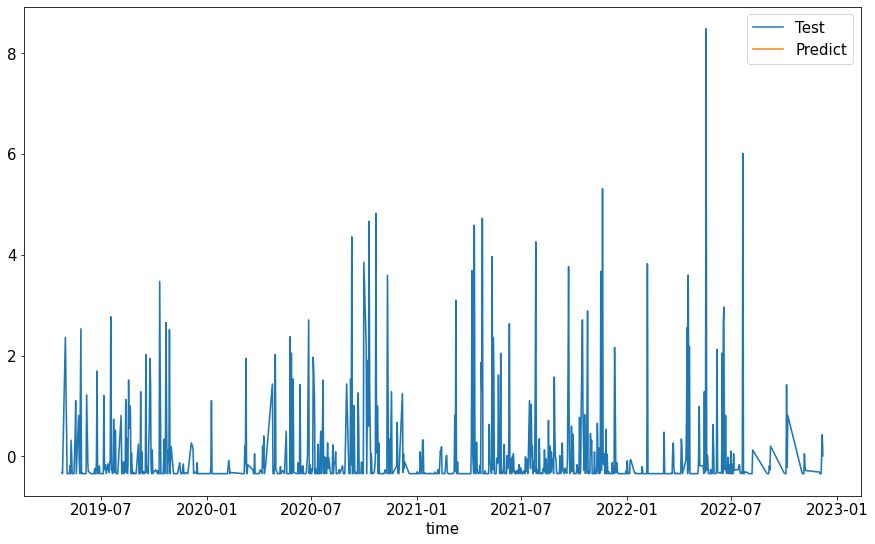

In [37]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['time'], len(y_train), window=window)

In [28]:
feature, target = create_window(df_scaled['prcp'], df_scaled[['prcp']], window=10)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_lstm(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
669/669 [==============================] - 6s 7ms/step - loss: nan - val_loss: nan
Epoch 2/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 3/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 4/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 5/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 6/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 7/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 8/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 9/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 10/50
669/669 [==============================] - 4s 6ms/step - loss: nan - val_loss: nan
Epoch 11/50
669/669 [==============================] - 4s 6

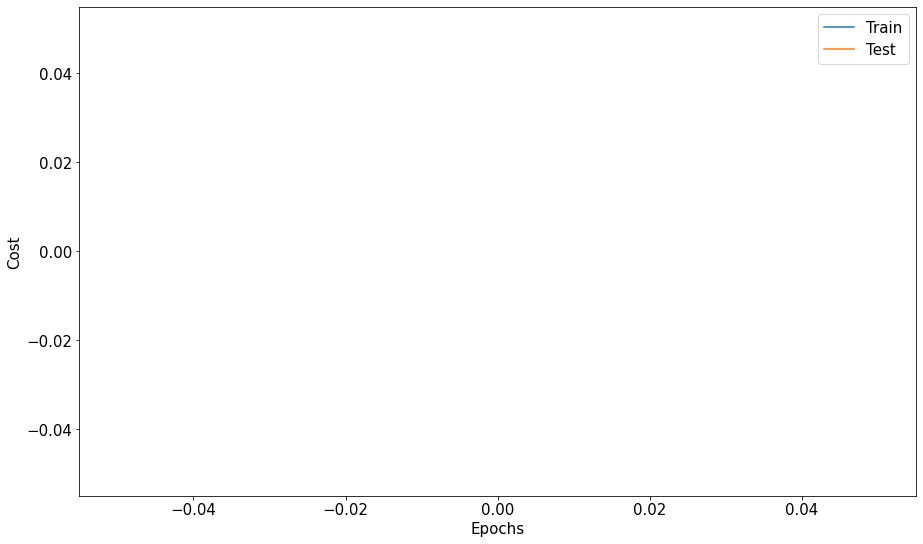

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


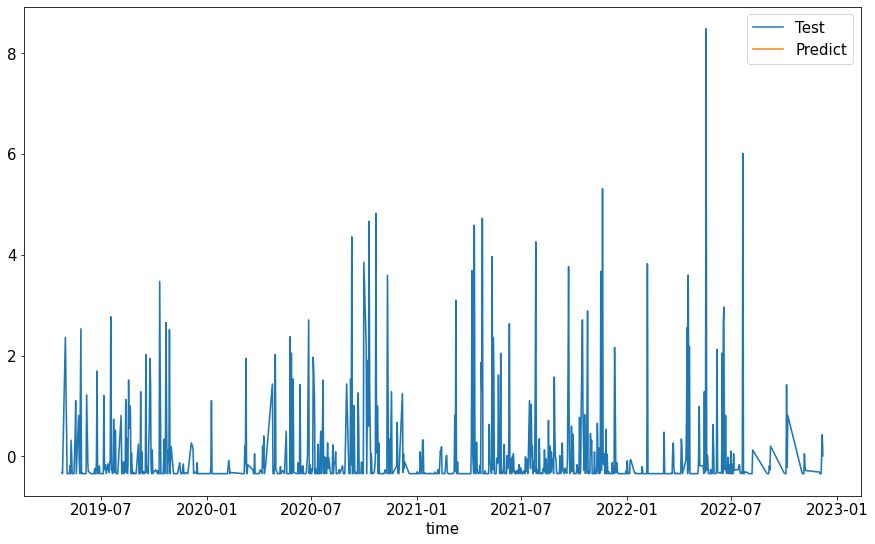

In [29]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['time'], len(y_train), window=window)